**Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.**

### **1. Importing all the important libraries**

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from glob import glob
import zipfile

In [ ]:
# Import data by mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#Opens the zip file in read mode
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment.zip', 'r') 
#Extracts the files into the /tmp folder
zip_ref.extractall('/tmp') 
zip_ref.close()

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of images used for training", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of images used for testing", image_count_test)

Number of images used for training 2239
Number of images used for testing 118


### **2.** **Data** **Preparation**

#### **2.1 Define some parameters for the loader**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **2.2 Create training dataset with 80% of the images**

In [ ]:
# create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


#### **2.3 Create validation dataset with 20% of the images**

In [ ]:
# create validation dataset 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# store class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **3. Visualize the data**


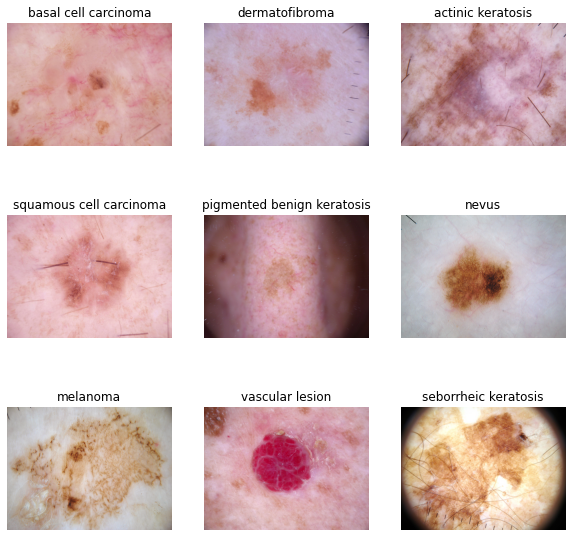

In [ ]:
# visualize one instance of all the nine classes present in the dataset
cnt=0

plt.figure(figsize=(10, 10))
for dirpath, dirnames, filenames in os.walk(str(data_dir_train)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,cnt+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        cnt=cnt+1

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **4. Model 1**


#### **4.1 Creating the model**

In [ ]:
# create model with convolution layers and batch normalization
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

#### **4.2 Compiling the model**

In [ ]:
# compile model with adam optimizer and binary_crossentropy as loss
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### **4.3 Training the model**

In [ ]:
# train model 
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 63ms/step - loss: 1.7667 - accuracy: 0.3331 - val_loss: 19.7824 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 3s 60ms/step - loss: 0.3525 - accuracy: 0.3153 - val_loss: 20.2960 - val_accuracy: 0.0537
Epoch 3/20
56/56 [==============================] - 3s 60ms/step - loss: 0.3018 - accuracy: 0.4191 - val_loss: 18.0580 - val_accuracy: 0.0537
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 0.2775 - accuracy: 0.4782 - val_loss: 11.7178 - val_accuracy: 0.0559
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 0.2643 - accuracy: 0.4994 - val_loss: 5.6963 - val_accuracy: 0.1521
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 0.2569 - accuracy: 0.5095 - val_loss: 2.4703 - val_accuracy: 0.1588
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 0.2538 - accuracy: 0.5285 - val_loss: 1.5347 - val_accuracy: 0.2215
Epoch 8/2

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_13 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 90, 90, 64)      

#### **4.4 Visualizing training results**

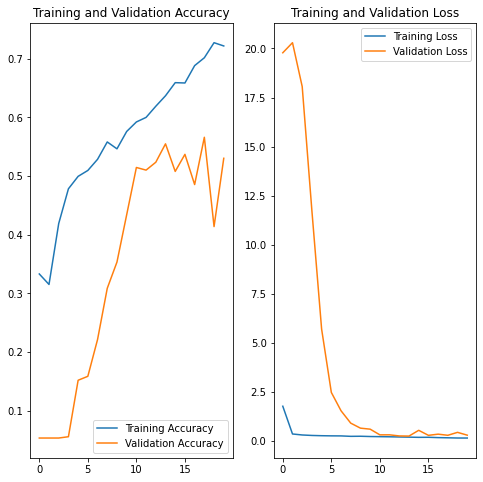

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **4.5 Observations**
#### 1. The training accuracy obtained is around 72% and validation is 53%
#### 2. In the graph it is seen that the model is overfitting as the difference between training and validation accuracy is more. Hence, we need to add dropout layer
#### 3. Next we'll build model without batch normalization to check accuracy

### **5 .Model 2**

#### **5.1 Creating the Model**

In [ ]:
# create model with convolution layers and removing batch normalization
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

#### **5.2 Compiling the model**

In [ ]:
# compile model with adam optimizer and binary_crossentropy as loss
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### **5.3 Training the model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 154s 3s/step - loss: 0.3680 - accuracy: 0.1964 - val_loss: 0.3516 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 138s 2s/step - loss: 0.3171 - accuracy: 0.2840 - val_loss: 0.2892 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 134s 2s/step - loss: 0.2764 - accuracy: 0.4141 - val_loss: 0.2618 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 136s 2s/step - loss: 0.2567 - accuracy: 0.4754 - val_loss: 0.2512 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 137s 2s/step - loss: 0.2468 - accuracy: 0.4983 - val_loss: 0.2506 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 137s 2s/step - loss: 0.2284 - accuracy: 0.5502 - val_loss: 0.2396 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 139s 2s/step - loss: 0.2284 - accuracy: 0.5441 - val_loss: 0.2535 - val_accuracy: 0.4855
Epoch 8/20
56

#### **5.4 Visualizing training results**

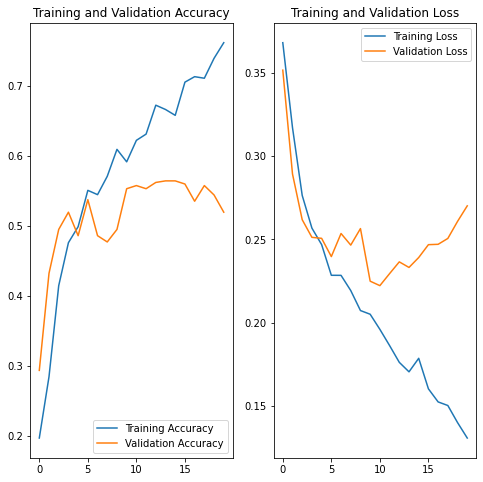

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **5.5 Observations**
#### 1. The training accuracy obtained is around 76% and validation is 52%
#### 2. These results are almost same with the model which was built using batch normalization because rescaling is same as batch normalization
#### 3. In the graph it is seen that the model is overfitting as the difference between training and validation accuracy is more. Hence, we need to add dropout layer
#### 4. Next we'll build model with dropout layers to reduce overfitting

### **6. Model 3**

#### **6.1 Creating the model**

In [ ]:
# create model with convolution layers and dropout layers
model_update=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

#### **6.2 Compiling the model**

In [ ]:
# compile model with adam optimizer and binary_crossentropy as loss
model_update.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

#### **6.3 Training the model**

In [ ]:
epochs = 20
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 96ms/step - loss: 2.1190 - accuracy: 0.1814 - val_loss: 2.0652 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0401 - accuracy: 0.1853 - val_loss: 2.0277 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0352 - accuracy: 0.1830 - val_loss: 2.0252 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0315 - accuracy: 0.1920 - val_loss: 2.0386 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 5s 95ms/step - loss: 1.9556 - accuracy: 0.2595 - val_loss: 1.8585 - val_accuracy: 0.3468
Epoch 6/20
56/56 [==============================] - 5s 95ms/step - loss: 2.0263 - accuracy: 0.2266 - val_loss: 2.0222 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 5s 96ms/step - loss: 2.0300 - accuracy: 0.2148 - val_loss: 2.0240 - val_accuracy: 0.2058
Epoch 8/20
56

#### **6.4 Visualizing training results**

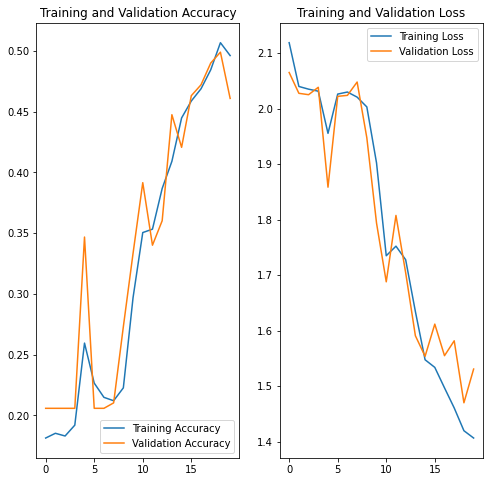

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **6.5 Observations**
#### 1. The training accuracy obtained is around 50% & validation accuracy is around 46%
#### 2. It can be observed that by adding dropout layers we are able to reduce overfitting to some extent
#### 3. The accuracy obtained is low. Now we'll build model after data augmentation

### **7. Data Augmentation**

#### **7.1 Define the augmentation**

In [ ]:
# using data augmentation to reduce overfitting, here random flip, rotation and zoom are applied to image
from tensorflow.keras import layers
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(.1, .1)
])

#### **7.2 Visualize augmentated data**

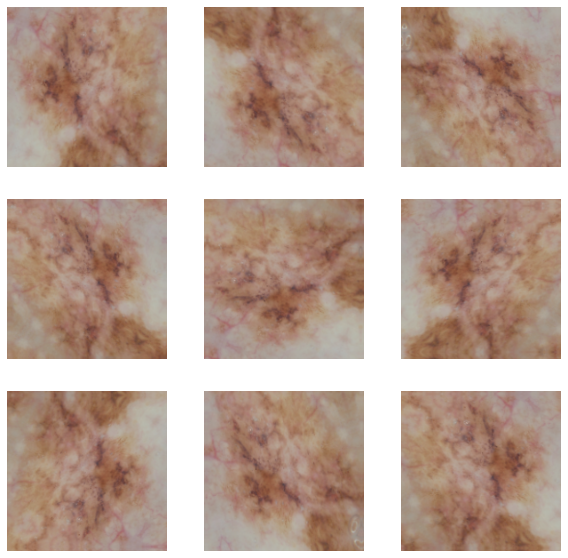

In [ ]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

### **8. Model 4**

#### **8.1 Creating the model**

In [ ]:
# create model with convolution layers and dropout layers on augmentated data
model_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])


#### **8.2 Compiling the model**

In [ ]:
# compile model with adam optimizer and binary_crossentropy as loss
model_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

#### **8.3 Training the model**

In [ ]:
epochs = 20
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 125ms/step - loss: 2.2370 - accuracy: 0.1948 - val_loss: 2.0227 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 7s 118ms/step - loss: 2.0356 - accuracy: 0.2003 - val_loss: 2.0339 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 115ms/step - loss: 2.0212 - accuracy: 0.1897 - val_loss: 2.0329 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 6s 115ms/step - loss: 2.0280 - accuracy: 0.2003 - val_loss: 2.0270 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 6s 114ms/step - loss: 2.0083 - accuracy: 0.2232 - val_loss: 2.0109 - val_accuracy: 0.2192
Epoch 6/20
56/56 [==============================] - 6s 115ms/step - loss: 1.8969 - accuracy: 0.2963 - val_loss: 1.8308 - val_accuracy: 0.3378
Epoch 7/20
56/56 [==============================] - 6s 114ms/step - loss: 1.8209 - accuracy: 0.3175 - val_loss: 1.8490 - val_accuracy: 0.3177
Epoch 

#### **8.4 Visualizing the results**

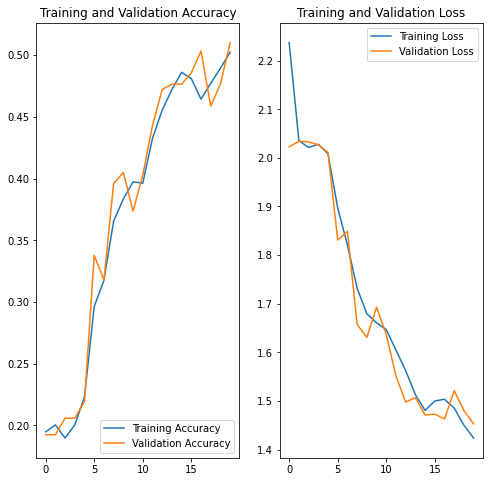

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **8.5 Observations**
#### 1. The training and validation accuracy is around 51% 
#### 2. With data augmentation there is no overfitting 
#### 3. This model seems to be good as compared to previous model
#### 4. The accuracy obtained is less, so we need to check for class imbalance 

### **9. Checking for class imbalance**

#### **9.1 Visualize number of samples for each disease**

In [ ]:
# find number of images for each disease in train dataset
train_path = '/tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
df1 = []
for i in class_names:
    count_list = []
    directory =train_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')
    count_list.append(i)
    count_list.append(length)
    df1.append(count_list)
df2 = pd.DataFrame(df1, columns=['Disease','count'])

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


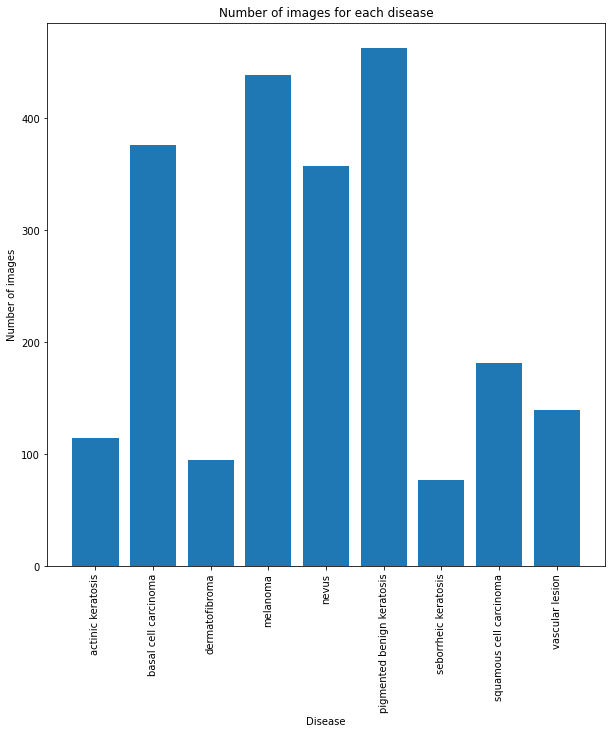

In [ ]:
# plot of disease vs number of images for each disease
plt.figure(figsize=(10, 10))
import matplotlib.pyplot as plt
plt.bar(df2['Disease'], df2['count'], align='center')
plt.xticks(rotation=90)
plt.title("Number of images for each disease")
plt.xlabel("Disease")
plt.ylabel("Number of images")
plt.show()

#### **9.2 Observation** 
#### 1. It is observed that there is no even distribution of number of samples per disease. Hence, there is class imbalance which needs to be handled
#### 2. seborrheic keratosis has least number of samples
#### 3. pigmented benign keratosis has more number of samples


### **10. Class imbalance treatment**
#### **10.1 Install Augmentor**

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### **10.2 Using Augmentor**

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # add 500 samples per class 
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6E21B8040>: 100%|██████████| 500/500 [00:18<00:00, 26.36 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6E216D760>: 100%|██████████| 500/500 [00:23<00:00, 20.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE730017A90>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE7447878B0>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FE6E20D14F0>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6E20EFB50>: 100%|██████████| 500/500 [00:16<00:00, 29.76 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE7AD25C4C0>: 100%|██████████| 500/500 [00:42<00:00, 11.86 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE73002FA90>: 100%|██████████| 500/500 [00:17<00:00, 29.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6E217A430>: 100%|██████████| 500/500 [00:16<00:00, 30.71 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [ ]:
# ensure there are 4500 total samples
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### **10.3 Distribution of augmented data after adding new images to the original training data**

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
# find number of samples after adding more samples
for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')


actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **11. Creating model from augmentated data**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **11.1 Creating training dataset**

In [ ]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **11.2 Creating validation dataset** 

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **11.3 Creating the model** 

In [ ]:
# create model with convolution layers and dropout layers
model_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

#### **11.4 Compiling the model** 

In [ ]:
# compile model with adam optimizer and binary_crossentropy as loss
model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

#### **11.5 Train the model**  

In [ ]:
epochs = 30
history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 [==============================] - 36s 158ms/step - loss: 2.7144 - accuracy: 0.2060 - val_loss: 1.8489 - val_accuracy: 0.3341
Epoch 2/30
169/169 [==============================] - 28s 160ms/step - loss: 1.6376 - accuracy: 0.3815 - val_loss: 1.7284 - val_accuracy: 0.3942
Epoch 3/30
169/169 [==============================] - 28s 163ms/step - loss: 1.4778 - accuracy: 0.4457 - val_loss: 1.3426 - val_accuracy: 0.4967
Epoch 4/30
169/169 [==============================] - 27s 153ms/step - loss: 1.3349 - accuracy: 0.5033 - val_loss: 1.2814 - val_accuracy: 0.5293
Epoch 5/30
169/169 [==============================] - 27s 153ms/step - loss: 1.2276 - accuracy: 0.5354 - val_loss: 1.1894 - val_accuracy: 0.5657
Epoch 6/30
169/169 [==============================] - 27s 153ms/step - loss: 1.1301 - accuracy: 0.5823 - val_loss: 1.1079 - val_accuracy: 0.6036
Epoch 7/30
169/169 [==============================] - 28s 162ms/step - loss: 1.0209 - accuracy: 0.6239 - val_loss: 1.0647 - val_ac

#### **11.6 Visualizing the model**  

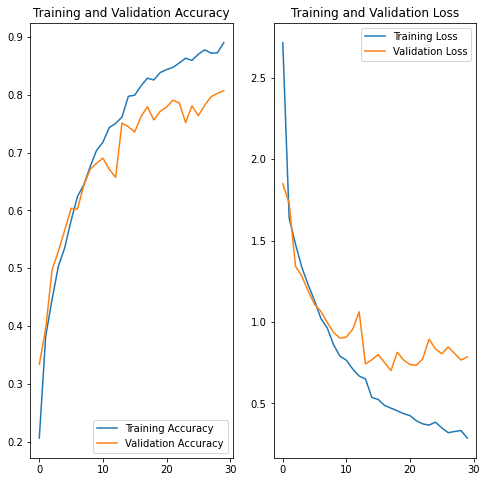

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **11.7 Observation** 
#### 1. **The model is able to classify disease with training accuracy of 89% and validation accuracy of 81%**
#### 2. With the help of class imbalance treatment we are able to improve accuracy
#### 3. Overfitting is also reduced with data augmentation and class imbalance treatment
